In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import random
from torch.autograd import Variable

In [2]:
import random
from torch.autograd import Variable

In [3]:
df = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/preprocessed_40part_testdataset.h5")

In [4]:
dt = df.values

In [5]:
dt.shape

(1100000, 121)

In [6]:
idx = dt[:,120]
bkg_idx = np.where(idx==0)[0]
sig_idx = np.where(idx==1)[0]

In [7]:
dt = dt[:,:120]
label = idx

In [8]:
dt.shape

(1100000, 120)

In [9]:
label.shape

(1100000,)

In [10]:
data = np.reshape(dt, (-1,40,3))

In [11]:
data.shape

(1100000, 40, 3)

In [12]:
label

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
data_bkg = dt[bkg_idx]

data_sig = dt[sig_idx]

data_bkg = data_bkg[:,0:120]

data_sig = data_sig[:,0:120]

data_bkg = np.reshape(data_bkg, (-1,40,3))

data_bkg.shape # (Nevents, Npfcands, Nfeats)

data_sig = np.reshape(data_sig, (-1,40,3))

data_sig.shape

(100000, 40, 3)

# MAKE DATASET

In [14]:
import torch
from torch_geometric.data import InMemoryDataset, download_url

In [ ]:
class DijetAnomaly(InMemoryDataset):
    

# Make Plotting Scripts, Will later make into a separate module

In [27]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10000, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    fig.savefig(f'figures/{name}.png')

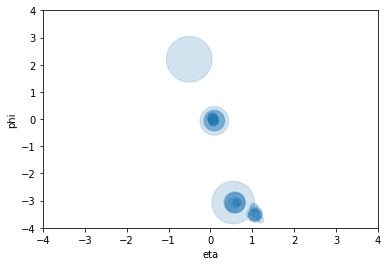

In [34]:
plot_event(data_sig[4],"event_sig_idx4")

# 40 Body System, 3 features ( pT, eta, Phi) for each object (PF candidate)

In [14]:
n_objects  = 40 # number of PF candidates(nodes)
object_dim = 3 # features: mass, x coordinate, y coordinate, speed on x-axis, speed on y-axis

n_relations  = n_objects * (n_objects - 1) # number of edges in fully connected graph
relation_dim = 1

effect_dim = 10 #effect's vector size


In [15]:
n_relations

1560

In [16]:
data.shape

(1100000, 40, 3)

In [17]:
def get_batch(data, label, idx, batch_size):
    
    start_idx = idx*batch_size
    end_idx = idx*batch_size+batch_size

    batch_data = data[start_idx: end_idx]
    label_data = label[start_idx: end_idx]
    
    objects = batch_data
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    #There is no relation info in solar system task, just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target))
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    return objects, sender_relations, receiver_relations, relation_info, target


In [18]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [19]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size, D):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1), #speedX and speedY
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] speedX and speedY
        '''
        input_size = x.size(2)*x.size(1)
        x = x.view(-1, input_size)
        return self.layers(x)


In [20]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, object_dim, n_relations, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel((object_dim + effect_dim)*n_objects, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [21]:
USE_CUDA = True

In [22]:
interaction_network = InteractionNetwork(n_objects, object_dim, n_relations, relation_dim, effect_dim)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.BCEWithLogitsLoss()



In [ ]:
n_epoch = 100
batch_size=1000
batches_per_epoch = int(len(data)/batch_size)

losses = []
for epoch in range(n_epoch):
    for idx in range(batches_per_epoch):
        print((idx/batches_per_epoch)*100,"percent")
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(data, label, idx, batch_size)
        predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
        loss = criterion(predicted.flatten(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy())
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()

0.0 percent
0.09090909090909091 percent
0.18181818181818182 percent
0.27272727272727276 percent
0.36363636363636365 percent
0.45454545454545453 percent
0.5454545454545455 percent
0.6363636363636364 percent
0.7272727272727273 percent
0.8181818181818182 percent
0.9090909090909091 percent
1.0 percent
1.090909090909091 percent
1.1818181818181819 percent
1.2727272727272727 percent
1.3636363636363635 percent
1.4545454545454546 percent
1.5454545454545454 percent
1.6363636363636365 percent
1.7272727272727273 percent
1.8181818181818181 percent
1.9090909090909092 percent
2.0 percent
2.090909090909091 percent
2.181818181818182 percent
2.272727272727273 percent
2.3636363636363638 percent
2.4545454545454546 percent
2.5454545454545454 percent
2.6363636363636362 percent
2.727272727272727 percent
2.8181818181818183 percent
2.909090909090909 percent
3.0 percent
3.090909090909091 percent
3.1818181818181817 percent
3.272727272727273 percent
3.3636363636363638 percent
3.4545454545454546 percent
3.54545454